In [1]:
!pip install peft awswrangler deep_translator transformers langdetect

In [2]:
import awswrangler as wr
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
from transformers import pipeline, AutoTokenizer
import re
import math
import time
import matplotlib.pyplot as plt
from importlib import reload
from pydantic import BaseModel, field_validator
import re
plt=reload(plt)

2025-05-08 07:07:31.909840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 07:07:31.923033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-08 07:07:31.941447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-08 07:07:31.947189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 07:07:31.960707: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# 1. Load data
phish_path = "s3://accsec-ai-prod-snitchmail/processed/phish/user_data.parquet"
phish_user_df = wr.s3.read_parquet(path=phish_path)

2025-05-02 09:40:39,686	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1895788544 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.55gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-02 09:40:40,887	INFO worker.py:1821 -- Started a local Ray instance.


In [63]:
# 2. Text cleaning functions
def clean_email_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special Unicode characters
    text = re.sub(r'[\x00-\x1F\x7F-\x9F\u200c\xa0]', ' ', text)
    # Collapse multiple whitespaces
    return re.sub(r'\s+', ' ', text).strip()

def translate_text(text):
    try:
        if detect(text) != 'en':
            return GoogleTranslator(source='auto', target='en').translate(text)
        return text
    except Exception as e:
        return text  # Return original if translation fails

## ealvaradob Model
https://huggingface.co/ealvaradob/bert-finetuned-phishing

In [33]:
# 3. Initialize phishing detection pipeline
bert_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert_finetuned = pipeline(
    model='ealvaradob/bert-finetuned-phishing',
    tokenizer=bert_tokenizer,
    truncation=True,
    device=0
)

Device set to use cuda:0


In [42]:
texts = ["hi, how are your?", "Your payment is due in 2 days, click here (https://pay-pal.com/123) to pay the amount"]
bert_finetuned(texts)

[{'label': 'benign', 'score': 0.9996805191040039},
 {'label': 'phishing', 'score': 0.9999934434890747}]

In [16]:
# 4. Process dataframe in batches
def process_batch(df_batch, batch_size):
    # Make a deep copy to ensure independence
    batch = df_batch.copy()
    
    # Clean text
    batch['cleaned_text'] = batch['email_text'].apply(clean_email_text)
    
    # Translate non-English text
    batch['translated_text'] = batch['cleaned_text'].apply(translate_text)
    
    # Run phishing detection
    texts = batch['translated_text'].tolist()
    predictions = bert_finetuned(texts, batch_size=batch_size)
    
    # Extract labels
    batch['ealvaradob_bert_finetuned_label'] = [pred['label'] for pred in predictions]
    return batch

In [20]:
# Set batch sizes
inference_batch_size = 64  # For model inference
df_chunk_size = 1000       # Number of rows per DataFrame chunk (tune as needed)

results = []
total_rows = len(phish_user_df)
num_chunks = math.ceil(total_rows / df_chunk_size)

start_time = time.time()
for i in range(num_chunks):
    start_idx = i * df_chunk_size
    end_idx = min((i + 1) * df_chunk_size, total_rows)
    chunk = phish_user_df.iloc[start_idx:end_idx].copy()
    processed_chunk = process_batch(chunk, inference_batch_size)
    results.append(processed_chunk)
    if (i + 1) % 5 == 0 or (i + 1) == num_chunks:
        elapsed = time.time() - start_time
        print(f"[{time.strftime('%X')}] Processed batch {i + 1}/{num_chunks} ({end_idx}/{total_rows} rows) in {elapsed:.1f}s")


KeyboardInterrupt



In [ ]:
# 5. Combine results and save
final_df = pd.concat(results)

output_file = "s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet"
wr.s3.to_parquet(
    df=final_df,
    path=output_file,
    index=False
)

## Model Performance
Dataframe loaded of size: 5599 from s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet!     
Device set to use cuda:0    
Model initialized: ealvaradob/bert-finetuned-phishing!   
[07:37:18] Processed batch 1/6 (1000/5599 rows) in 37.4s   
[07:37:51] Processed batch 2/6 (2000/5599 rows) in 70.6s    
[07:38:22] Processed batch 3/6 (3000/5599 rows) in 101.2s   
[07:38:55] Processed batch 4/6 (4000/5599 rows) in 134.5s   
[07:39:30] Processed batch 5/6 (5000/5599 rows) in 169.4s   
[07:40:00] Processed batch 6/6 (5599/5599 rows) in 199.3s   
Saved Final Dataframe of size: 5599 to s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet!

In [88]:
# llm_model1_data = "s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet"
# llm_model1_df = wr.s3.read_parquet(path=llm_model1_data)
llm_model1_df = pd.read_parquet('csv_files/w_label/phish_user_emails_2.parquet')
suspended_user_data = pd.read_csv('csv_files/suspended_users_20250424.csv')

In [89]:
wr.s3.to_parquet(
        df=llm_model1_df,
        path="s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet",
        index=False
    )

{'paths': ['s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet'],
 'partitions_values': {}}

In [72]:
llm_model1_df.columns, suspended_user_data.columns

(Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'mime', 'email_from',
        'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
        'lang', 's3_path', 'Content-Type', 'email_text', 'cleaned_text',
        'translated_text', 'ealvaradob_bert_finetuned_label',
        'ealvaradob_bert_finetuned_score', 'elslay_bert_finetuned_label',
        'elslay_bert_finetuned_score',
        'cybersectony_distilbert_finetuned_label',
        'cybersectony_distilbert_finetuned_score'],
       dtype='object'),
 Index(['user_id', 'created_at'], dtype='object'))

In [73]:
llm_model1_df['email_date'].head()

0    2025-03-14
1    2025-02-22
2    2025-03-13
3    2025-02-23
4    2025-03-21
Name: email_date, dtype: string

In [74]:
suspended_user_data['created_at'].head()

0    2025-03-05 19:20:32
1    2025-03-13 08:18:54
2    2025-03-21 20:41:19
3    2025-02-24 13:25:19
4    2025-02-24 08:37:59
Name: created_at, dtype: object

In [75]:
llm_model1_df['email_date'] = pd.to_datetime(llm_model1_df['email_date'])
suspended_user_data['created_at'] = pd.to_datetime(suspended_user_data['created_at'])

# Merge on user_id
merged = pd.merge(llm_model1_df, suspended_user_data, on='user_id', how='inner')

# Filter: keep rows where email_date > (created_at - 3 days)
merged = merged[merged['email_date'] > (merged['created_at'] - pd.Timedelta(days=3))]

In [77]:
merged.shape, merged.columns

((575, 23),
 Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'mime', 'email_from',
        'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
        'lang', 's3_path', 'Content-Type', 'email_text', 'cleaned_text',
        'translated_text', 'ealvaradob_bert_finetuned_label',
        'ealvaradob_bert_finetuned_score', 'elslay_bert_finetuned_label',
        'elslay_bert_finetuned_score',
        'cybersectony_distilbert_finetuned_label',
        'cybersectony_distilbert_finetuned_score', 'created_at'],
       dtype='object'))

In [27]:
# llm_model1_df['ealvaradob_bert_finetuned_label'].value_counts()
llm_model1_df['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    4786
0     813
Name: count, dtype: int64

In [100]:
llm_model1_df[llm_model1_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    4212
Name: count, dtype: int64

In [101]:
4212*100/5599

75.22771923557778

In [62]:
llm_model1_df[llm_model1_df['email_text'] == ''].loc[158, 'mime']

'DKIM-Signature: v=1; a=rsa-sha256; c=relaxed/relaxed; d=smartlead.ai;\r\n\th=content-transfer-encoding:content-type:from:mime-version:subject:to:\r\n\tcc:content-type:from:subject:to;\r\n\ts=s1; bh=jNTQKuju0B7QLflVcm7ngh1WyjEpRP5Oagv6ISV3eNg=;\r\n\tb=SDhVHeVxP9v1XWq2sY8jlAjoMgssPmO0YKNNWg2vLYDA4Cvz9b6zaTr7apwxETIk6lny\r\n\t1ZBywgn9UOi7fw4qtLZg/GEE8gwLc65/r0tI8iPum/9o/IaHY6H0IptoVNzlB9FICcEkQV\r\n\tvT4Dv53fKynTdUq5Bv3NlIDlidUaikPBfnlsVghSUChLQaLBNhP+byJTEhbGnafK5LpLY7\r\n\t8wyjILrqnrGrHZ8zRi6BrtnFtFElJ1Zttp4TzFGhifzgSCQY9e8sODjqLegeQB1abkztxg\r\n\tzbOhiMTCxrxd6/Y8wvOx6IxF1gYLmj8+OKIaBbGug+0VoIqlD6Xv1Y+pQHU+/+Yg==\r\nDKIM-Signature: v=1; a=rsa-sha256; c=relaxed/relaxed; d=sendgrid.info;\r\n\th=content-transfer-encoding:content-type:from:mime-version:subject:to:\r\n\tcc:content-type:from:subject:to;\r\n\ts=smtpapi; bh=jNTQKuju0B7QLflVcm7ngh1WyjEpRP5Oagv6ISV3eNg=;\r\n\tb=cI+szky0mewQgh1sunpFNmT/gP/dZhfnHqMwjs0P/vywo3LJqUz9LZ9bDymKzfrmjbKy\r\n\tqfkPjm9Fmmn4lkl3k/JaeuJ1GuU9U71WqClwCsI6kQKv1

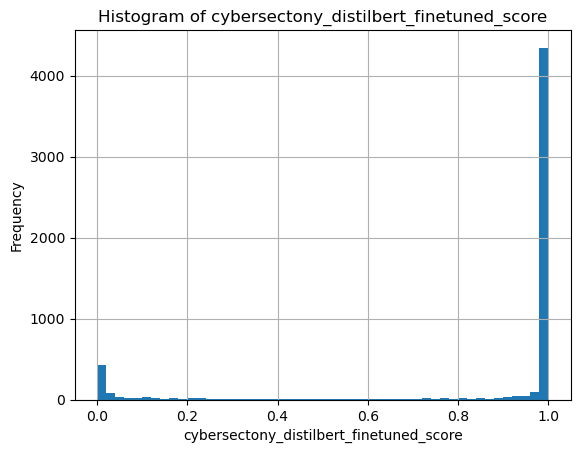

In [15]:
llm_model1_df['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/cybersectony_distilbert.png')
plt.show()

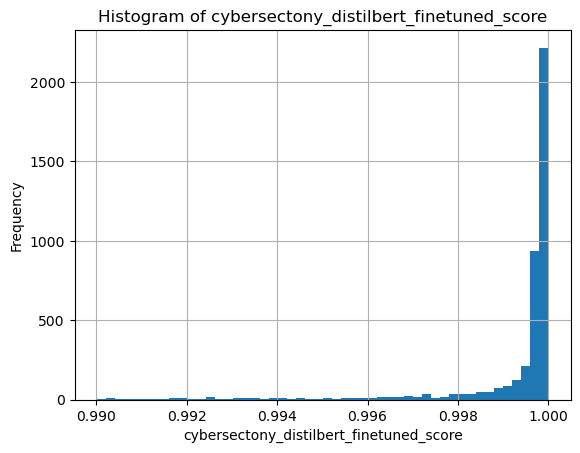

In [25]:
llm_model1_df[llm_model1_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/cybersectony_distilbert_0.99.png')
plt.show()

In [30]:
llm_model1_df['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    5202
0     397
Name: count, dtype: int64

In [97]:
llm_model1_df[llm_model1_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    3642
Name: count, dtype: int64

In [98]:
3642*100/5599

65.04732988033578

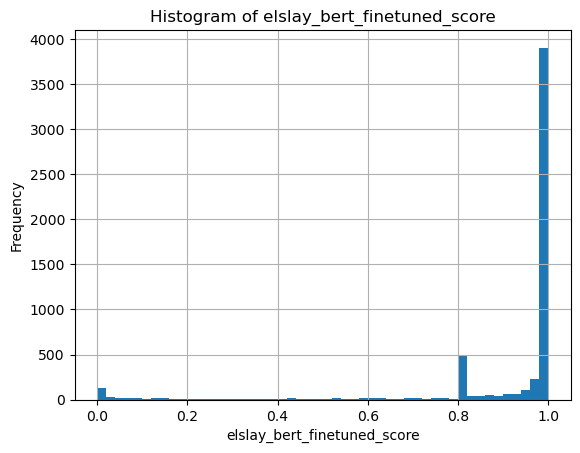

In [18]:
llm_model1_df['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/elslay_bert.png')
plt.show()

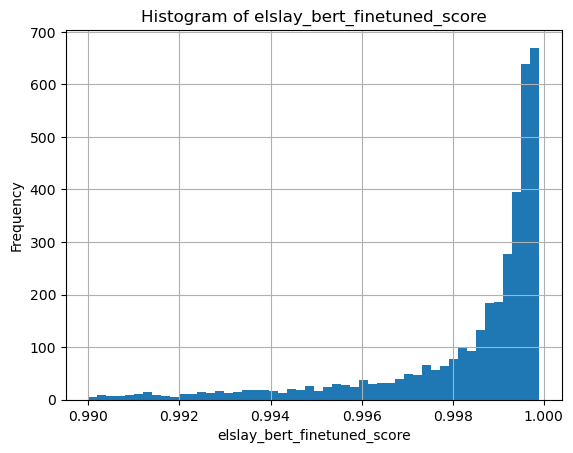

In [26]:
llm_model1_df[llm_model1_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/elslay_bert_0.99.png')
plt.show()

In [33]:
llm_model1_df['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    5376
0     223
Name: count, dtype: int64

In [102]:
llm_model1_df[llm_model1_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    4878
Name: count, dtype: int64

In [103]:
4878*100/5599

87.12270048222896

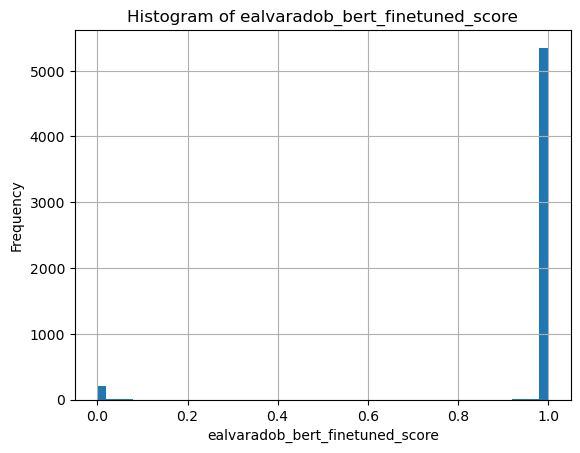

In [13]:
llm_model1_df['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/ealvaradob_bert.png')
plt.show()


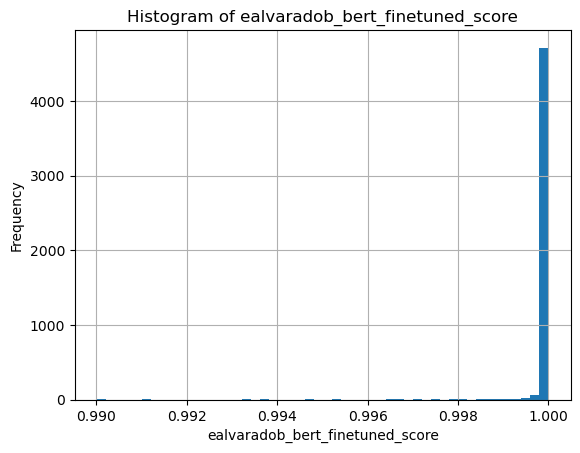

In [27]:
llm_model1_df[llm_model1_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/ealvaradob_bert_0.99.png')
plt.show()

In [45]:
llm_model1_df.loc[llm_model1_df['ealvaradob_bert_finetuned_label'] == 0, 'translated_text'][2]

"Dasha DeFoe ( # ) Welcome to the RAH Overland Park/Lawrence Mobile App. We're happy that you have joined us and we hope that you will enjoy using our app. CONTACT US: vicki@rahkc.com ( http://links.markedprivate.com ) ( http://links.markedprivate.com )"

In [10]:
# llm_model1_df.loc[llm_model1_df['ealvaradob_bert_finetuned_label'] == "phishing", 'ealvaradob_bert_finetuned_label_new'] = 1

In [12]:
# llm_model1_df = llm_model1_df.drop(columns=['ealvaradob_bert_finetuned_label'])
# llm_model1_df = llm_model1_df.rename(columns={'ealvaradob_bert_finetuned_label_new': 'ealvaradob_bert_finetuned_label'})

In [13]:
# wr.s3.to_parquet(
#     df=llm_model1_df,
#     path=llm_model1_data,
#     index=False
# )

{'paths': ['s3://accsec-ai-prod-snitchmail/processed/phish/labeled_user_data.parquet'],
 'partitions_values': {}}

In [125]:
llm_model1_df.columns

Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'mime', 'email_from',
       'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
       'lang', 's3_path', 'Content-Type', 'email_text', 'cleaned_text',
       'translated_text', 'ealvaradob_bert_finetuned_label',
       'ealvaradob_bert_finetuned_score',
       'cybersectony_distilbert_finetuned_label',
       'cybersectony_distilbert_finetuned_score',
       'elslay_bert_finetuned_label', 'elslay_bert_finetuned_score'],
      dtype='object')

In [118]:
llm_model1_df.loc[0, ['email_text', 'cleaned_text']]

email_text      ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌\r\n\r\n \r...
cleaned_text    Charmaine ( # ) You have successfully reset yo...
Name: 0, dtype: object

In [119]:
llm_model1_df.loc[0, 'email_text']

'\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\xa0\u200c\r\n\r\n \r\n\r\n\r\nCharmaine ( # )\r\nYou have successfully reset your password!\r\n\r\nIf you did not request this password reset, please ignore this email or contact us.\r\n\r\n\r\nCONTACT US: tylerc@comfortkeepers424.com\r\n\r\n ( http://links.markedprivate.com/ls/click?upn=u001.HTFIEHL-2Fh61CCsV1HYSO-2BwoQl46DtE9vfCZ8HTvaBV-2FeurN-2BFIVmttQk-2BoZpainzaCap6Nd5WnMuFB3VW3RchZU35a-2Bc-2F7-2F1h-2FicK7dcKazdaDLTmjaG-2F5xiyDnD-2FeixrHCG6dIOzkHaXgujXrwaOQ-3D-3DI1Fj_hGPmNfPiK7S739TIhW55fQR-2FImlIHMvY6UiZ40Hry107ILbphz1rUjmDTDWhxMu46VovlkZgEtoa5jMNQBgEaE6XHwYP98XaFbPk3TbmbZ-2BY5-2BjCeRd9R0vmkrfkt5qs-2FoXtGkhcH5NVGJNwO6nRGIR1M-2FGzmXAB9usJyd2thsIp5i2x1CRBDfycFbWU46Xw2gBktwxJK96XhwK6eqUCFH35vfZfdWXe5Svw71gaQRoxoJWBqHikAn2p7n4ss-2Bxn6047SRI-2FJ6YVr01VnO1XslgxLhaO1MUy8VLbUq10CLhUJQvImUWdoez6rDTlBkDRlEDkFJ-2BdXqEYImiaFh8

In [120]:
llm_model1_df.loc[0, 'cleaned_text']

'Charmaine ( # ) You have successfully reset your password! If you did not request this password reset, please ignore this email or contact us. CONTACT US: tylerc@comfortkeepers424.com ( http://links.markedprivate.com/ls/click?upn=u001.HTFIEHL-2Fh61CCsV1HYSO-2BwoQl46DtE9vfCZ8HTvaBV-2FeurN-2BFIVmttQk-2BoZpainzaCap6Nd5WnMuFB3VW3RchZU35a-2Bc-2F7-2F1h-2FicK7dcKazdaDLTmjaG-2F5xiyDnD-2FeixrHCG6dIOzkHaXgujXrwaOQ-3D-3DI1Fj_hGPmNfPiK7S739TIhW55fQR-2FImlIHMvY6UiZ40Hry107ILbphz1rUjmDTDWhxMu46VovlkZgEtoa5jMNQBgEaE6XHwYP98XaFbPk3TbmbZ-2BY5-2BjCeRd9R0vmkrfkt5qs-2FoXtGkhcH5NVGJNwO6nRGIR1M-2FGzmXAB9usJyd2thsIp5i2x1CRBDfycFbWU46Xw2gBktwxJK96XhwK6eqUCFH35vfZfdWXe5Svw71gaQRoxoJWBqHikAn2p7n4ss-2Bxn6047SRI-2FJ6YVr01VnO1XslgxLhaO1MUy8VLbUq10CLhUJQvImUWdoez6rDTlBkDRlEDkFJ-2BdXqEYImiaFh8i4cTRS1IKciiXaGVCYBBeRR0-3D ) ( http://links.markedprivate.com/ls/click?upn=u001.HTFIEHL-2Fh61CCsV1HYSO-2By8-2BR37xifERHFqL0ppa9MNXrfRl0Zmc5-2BeFTbA1skcxXpvnUHTVgMmxYSsA7TcrNDgYk6wIXrZWVEPnK2EH3BQ-3DLk12_hGPmNfPiK7S739TIhW55fQ

In [76]:
clean_email_text(llm_model1_df.loc[0, 'email_text'])

'Charmaine ( # ) You have successfully reset your password! If you did not request this password reset, please ignore this email or contact us. CONTACT US: tylerc@comfortkeepers424.com ( http://links.markedprivate.com/ls/click?upn=u001.HTFIEHL-2Fh61CCsV1HYSO-2BwoQl46DtE9vfCZ8HTvaBV-2FeurN-2BFIVmttQk-2BoZpainzaCap6Nd5WnMuFB3VW3RchZU35a-2Bc-2F7-2F1h-2FicK7dcKazdaDLTmjaG-2F5xiyDnD-2FeixrHCG6dIOzkHaXgujXrwaOQ-3D-3DI1Fj_hGPmNfPiK7S739TIhW55fQR-2FImlIHMvY6UiZ40Hry107ILbphz1rUjmDTDWhxMu46VovlkZgEtoa5jMNQBgEaE6XHwYP98XaFbPk3TbmbZ-2BY5-2BjCeRd9R0vmkrfkt5qs-2FoXtGkhcH5NVGJNwO6nRGIR1M-2FGzmXAB9usJyd2thsIp5i2x1CRBDfycFbWU46Xw2gBktwxJK96XhwK6eqUCFH35vfZfdWXe5Svw71gaQRoxoJWBqHikAn2p7n4ss-2Bxn6047SRI-2FJ6YVr01VnO1XslgxLhaO1MUy8VLbUq10CLhUJQvImUWdoez6rDTlBkDRlEDkFJ-2BdXqEYImiaFh8i4cTRS1IKciiXaGVCYBBeRR0-3D ) ( http://links.markedprivate.com/ls/click?upn=u001.HTFIEHL-2Fh61CCsV1HYSO-2By8-2BR37xifERHFqL0ppa9MNXrfRl0Zmc5-2BeFTbA1skcxXpvnUHTVgMmxYSsA7TcrNDgYk6wIXrZWVEPnK2EH3BQ-3DLk12_hGPmNfPiK7S739TIhW55fQ

In [29]:
llm_model1_df.loc[0, ['translated_text', 'ealvaradob_bert_finetuned_label']]

translated_text                    Charmaine ( # ) You have successfully reset yo...
ealvaradob_bert_finetuned_label                                                    1
Name: 0, dtype: object

In [21]:
llm_model1_df.loc[100, 'email_text']

'Email Summary (Hidden)\r\n\r\nASSA ( https://u7955388.ct.sendgrid.net/ls/click?upn=u001.gpDy-2BCrh21QuHODl-2B3-2B4vOaycBetlaBAd43ICNgPKq0-3DX_Fd_JYhbNyW75sBr60sqm5-2BppKJseRxserMNtEaOKMT5JATSkve9ZgoKB732b7ba-2B0A6jOli3VhFp2hbWn3z1UotUka-2BfpTLj-2F-2FnSLSU2F47mZ6-2Fs3uDwxBxwnXZcjIUyYHnRhuuN66eCWcEwbt5-2FFSBlxjKJxJEMVtCmKwk-2FvGx7ARW9-2B0ve36-2FmrqnuCIaurJ1LpuMIgWdHINNYzv9LTXB6drq8R1T4KBvkvJxF3KeHeFM0sV-2BJv-2FN0hK9KwOuxN190cszpO0dfxLxzl52Y-2FFllbipxfRQQoA1dxQ5XhCpiWjRecEUm2op1k1WrKXxM8g1FrKxr9rU39kF-2BtC4zzRNog-3D-3D )\r\n\r\n*******************\r\nFactura Electrónica\r\n*******************\r\n\r\nEstimado(a) BLANCO ESTEVEZ, JOSE CARLOS\r\n\r\nAdjunto encontrará su *Factura Número* 0002716621, *emitida el* 2025-03-27T06:39:10-05:00\r\n*CUFE:* FE0120000003724-103-53659-4300012025032700027166210010110026619376\r\n*No° de Protocolo de Autorización emitido por la DGI* 1556464632201758719820250327064155862417.\r\n\r\n*Importe total: $  54.08*\r\n\r\n*Estamos para Servirle!*\r\nAtentamente,\

In [23]:
llm_model1_df.loc[100, 'translated_text']

'Email Summary (Hidden) Assa () ********************* Electronic invoice ********************** Estimated (a) White Estevez, Jose Carlos attached you will find its*invoice number*0002716621,*Issued the*2025-03-27t06: 39: 10-05: 10-05: *CUFE: *FE0120000003724-103-53659-4300012025032700027166210010110026619376 *No authorization protocol issued by the DGI *15564646322017587198202503270641555862417 54.08** We are to serve him!* Attentively,* Assa Compañía de Seguros, S.A* Regulated and supervised by the Superintendence of Insurance and Reinsurance of Panama. Powered by @Hypernovalabs () Help Center () • Preferences () • Unsubscribe ()'

## ElSlay Model
https://huggingface.co/ElSlay/BERT-Phishing-Email-Model

In [115]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Replace with your Hugging Face model repo name
model_name = 'ElSlay/BERT-Phishing-Email-Model'

# Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Ensure the model is in evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [116]:
# Input email text
email_text = "Hi Aman, how are you doing? I am doing good. Wanted to know when we could meet next."
email_text = "http://links.markedprivate.com"

# Tokenize and preprocess the input text
inputs = tokenizer(email_text, return_tensors="pt", truncation=True, padding='max_length', max_length=512)

# Make the prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    probs = torch.softmax(logits, dim=-1)
    confs = probs.max(dim=-1)

# Interpret the prediction
result = "Phishing" if predictions.item() == 1 else "Legitimate"
confidence = confs.values.numpy().item()
print(f"Prediction: {result}")
print(f"Confidence Score = {confidence}")

Prediction: Phishing
Confidence Score = 0.996417760848999


## cybersectony Model
https://huggingface.co/cybersectony/phishing-email-detection-distilbert_v2.4.1

In [117]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("cybersectony/phishing-email-detection-distilbert_v2.4.1")
import torch

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cybersectony/phishing-email-detection-distilbert_v2.4.1")

def predict_email(email_text):
    # Preprocess and tokenize
    inputs = tokenizer(
        email_text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get probabilities for each class
    probs = predictions[0].tolist()
    
    # Create labels dictionary
    labels = {
        "legitimate_email": probs[0],
        "phishing_email": probs[1],
        "legitimate_url": probs[2],
        "phishing_url": probs[3]
    }
    
    # Determine the most likely classification
    max_label = max(labels.items(), key=lambda x: x[1])
    
    return {
        "prediction": max_label[0],
        "confidence": max_label[1],
        "all_probabilities": labels
    }


In [118]:
# Example usage
# email = """
# Dear User,
# Your account security needs immediate attention. Please verify your credentials.
# Click here: http://suspicious-link.com
# """

# email = "Hi Aman, how are you doing? I am doing good. Wanted to know when we could meet next."
# email = "Your payment is due today of amount $200. If you have already paid please call to confirm."
email = "https://www.dcc.at https://bio.link/"
email = "http://links.markedprivate.com"

result = predict_email(email)
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nAll probabilities:")
for label, prob in result['all_probabilities'].items():
    print(f"{label}: {prob:.2%}")


Prediction: phishing_url
Confidence: 100.00%

All probabilities:
legitimate_email: 0.00%
phishing_email: 0.00%
legitimate_url: 0.00%
phishing_url: 100.00%


## AcuteShrewdSecurity/Llama-Phishsense-1B
https://huggingface.co/AcuteShrewdSecurity/Llama-Phishsense-1B

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

In [7]:

torch.cuda.empty_cache()  # Frees cached memory held by PyTorch allocator
torch.cuda.ipc_collect()  # Cleans up inter-process memory sharing
import gc
gc.collect()

0

In [38]:
tokenizer = AutoTokenizer.from_pretrained("AcuteShrewdSecurity/Llama-Phishsense-1B")
base_model = AutoModelForCausalLM.from_pretrained("AcuteShrewdSecurity/Llama-Phishsense-1B")
model = PeftModel.from_pretrained(base_model, "AcuteShrewdSecurity/Llama-Phishsense-1B")

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.to('cuda')

/opt/conda/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [56]:
# email_text = "Your payment is due today of amount $200. If you have already paid please call to confirm."
# email_text = "Hi Aman, how are you doing? I am doing good. Wanted to know when we could meet next."
# email_text = "Urgent: Your account has been flagged for suspicious activity. Please log in immediately."
email_text = llm_model1_df.loc[20, 'translated_text']

prompt = f"Classify the following text as phishing (TRUE) or not (FALSE):\n{email_text}\n<<ANSWER>>:"
inputs = tokenizer(prompt, return_tensors="pt")

# Move inputs to GPU if available
if torch.cuda.is_available():
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=5, temperature=0.001, do_sample=False)

response = tokenizer.decode(output[0], skip_special_tokens=True).split("<<ANSWER>>:")[1].strip()

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [57]:
response

'TRUETRUETRUE#'

In [132]:
tokenizer.decode(output[0], skip_special_tokens=True)

'Classify the following text as phishing or not. Respond with either \'TRUE\' or \'FALSE\'. Only one of them.:\n\nSheila Truncellito, ( # ) Lucelly Gordillo has completed the "Self Care Bingo" survey. These are the responses: Question: : Section 1: Physical Well-Being! Check all the activities you did or plan on doing today! Answer: Take a 10-minute walk outside Question: : Section 1: Physical Well-Being! Check all the activities you did or plan on doing today! Answer: Have at least 3 meals in the day Question: : Section 2: Mental &amp; Emotional Well-Being. Check all the activities you did or plan on doing today! Answer: Listen to your favorite song or playlist Question: : Section 2: Mental &amp; Emotional Well-Being. Check all the activities you did or plan on doing today! Answer: Set a small, realistic goal for the day Question: : Section 2: Mental &amp; Emotional Well-Being. Check all the activities you did or plan on doing today! Answer: Say &quot;no&quot; to something that drains

In [49]:
def majority_phishsense(response: str) -> int:
    """
    Given a model response string of 5 booleans concatenated (e.g., 'TRUETRUETRUETRUETRUE'),
    return 1 if the majority is TRUE (phishing), else 0 (not phishing).
    """
    # Normalize to uppercase and split every 4 or 5 letters
    response = response.upper().replace(" ", "")
    # Handle both 'TRUE' and 'FALSE' (4 and 5 letters)
    bools = []
    i = 0
    while i < len(response):
        if response[i:i+4] == "TRUE":
            bools.append(True)
            i += 4
        elif response[i:i+5] == "FALSE":
            bools.append(False)
            i += 5
        else:
            # Unexpected format, skip one char
            i += 1
    # Take only the first 5 values
    bools = bools[:5]
    # Return majority
    return int(sum(bools) >= 3)


In [50]:
majority_phishsense(response)

1

In [86]:
class PhishingResponse(BaseModel):
    is_phishing: int

    @field_validator('is_phishing', mode='before')
    @classmethod
    def extract_boolean(cls, v):
        # Find first TRUE/FALSE match (case-insensitive)
        if isinstance(v, str):
            match = re.search(r'\b(true|false)', v, re.IGNORECASE)
            if match:
                return 1 if match.group(1).lower() == 'true' else 0
        return 0  # Default if no valid match


In [87]:
def get_phishing_prediction(email_text: str) -> bool:
    # Model setup
    tokenizer = AutoTokenizer.from_pretrained("AcuteShrewdSecurity/Llama-Phishsense-1B")
    base_model = AutoModelForCausalLM.from_pretrained("AcuteShrewdSecurity/Llama-Phishsense-1B")
    model = PeftModel.from_pretrained(base_model, "AcuteShrewdSecurity/Llama-Phishsense-1B")
    
    if torch.cuda.is_available():
        model = model.to('cuda')
    
    # Generate response
    prompt = f"Classify as phishing (TRUE) or not (FALSE):\n{email_text}\n<<ANSWER>>:"
    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
    
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=5, temperature=0.001)
    
    # Parse response
    raw_response = tokenizer.decode(output[0], skip_special_tokens=True)
    # print(raw_response)
    answer = raw_response.split("<<ANSWER>>:")[-1].strip()
    # print(answer)
    match = re.search(r'\b(true|false)', answer, re.IGNORECASE)
    # print(match)
    # print(match.group(1).lower())
    
    # Validate with Pydantic
    return PhishingResponse(is_phishing=answer).is_phishing

In [88]:
get_phishing_prediction(llm_model1_df.loc[100, 'translated_text'])

/opt/conda/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1

In [82]:
re.search(r'\b(true|false)', "FALSETRUETRUETRUE", re.IGNORECASE).group(1).lower()

'false'

In [5]:
part1_files = wr.s3.list_objects("s3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data/")
part2_files = wr.s3.list_objects("s3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data_part2/")

2025-05-08 07:10:30,133	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1895755776 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.67gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-08 07:10:30,228	INFO worker.py:1786 -- Started a local Ray instance.


In [7]:
import random
good_user_files = part1_files + part2_files
random_4 = random.sample(good_user_files, 4)

In [8]:
random_4

['s3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data_part2/users_sample_710000-714999.parquet',
 's3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data_part2/users_sample_600000-604999.parquet',
 's3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data_part2/users_sample_760000-764999.parquet',
 's3://accsec-ai-prod-snitchmail/processed/not_phish/processed_unique_user_email_data/users_sample_55000-59999.parquet']

In [10]:
good_user_dfs = []
for file in random_4:
    df = wr.s3.read_parquet(path=file)
    good_user_dfs.append(df)

good_user_df = pd.concat(good_user_dfs)

In [11]:
good_user_df.shape

(20000, 12)

In [15]:
good_user_df.to_parquet('csv_files/wo_label/good_user_emails.parquet', index=False)

## Good User Model Analysis

In [167]:
good_user_labeled_df = pd.read_parquet('csv_files/w_label/good_user_emails_w_sub.parquet')

In [168]:
wr.s3.to_parquet(
        df=good_user_labeled_df,
        path="s3://accsec-ai-prod-snitchmail/processed/not_phish/labeled_good_user_data.parquet",
        index=False
    )

{'paths': ['s3://accsec-ai-prod-snitchmail/processed/not_phish/labeled_good_user_data.parquet'],
 'partitions_values': {}}

In [22]:
good_user_labeled_df.columns

Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'email_from', 'email_to',
       'email_date', 'originating_ip', 'originating_ip_country', 'lang',
       'Content-Type', 'email_text', 'cleaned_text', 'translated_text',
       'ealvaradob_bert_finetuned_label', 'ealvaradob_bert_finetuned_score',
       'elslay_bert_finetuned_label', 'elslay_bert_finetuned_score',
       'cybersectony_distilbert_finetuned_label',
       'cybersectony_distilbert_finetuned_score', 'subject_body'],
      dtype='object')

In [23]:
good_user_labeled_df['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    13170
0     6830
Name: count, dtype: int64

In [91]:
good_user_labeled_df[good_user_labeled_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    11863
Name: count, dtype: int64

In [92]:
11863*100/(13170+6830)

59.315

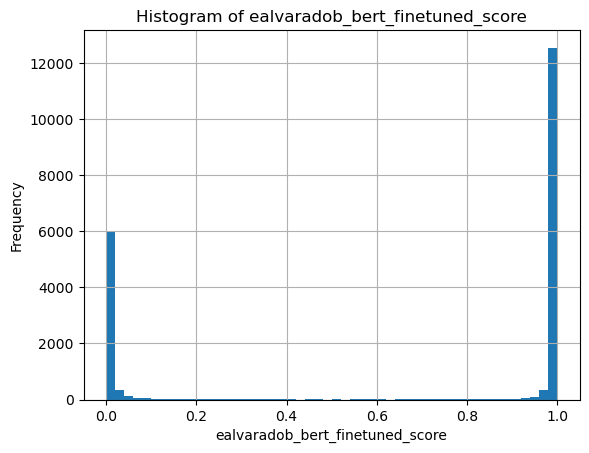

In [34]:
good_user_labeled_df['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_ealvaradob_bert.png')
plt.show()

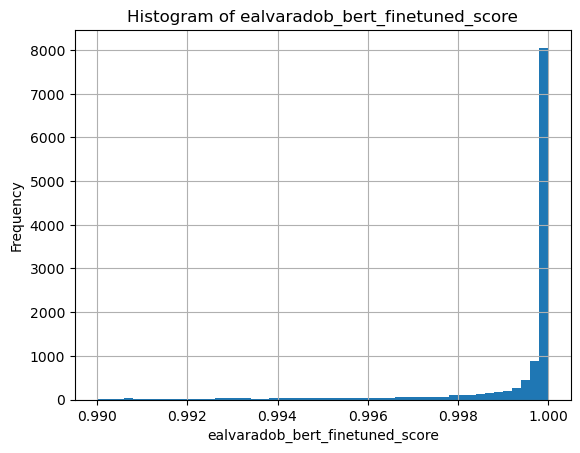

In [37]:
good_user_labeled_df[good_user_labeled_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_ealvaradob_bert_0.99.png')
plt.show()

In [70]:
good_user_labeled_df['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    12843
0     7157
Name: count, dtype: int64

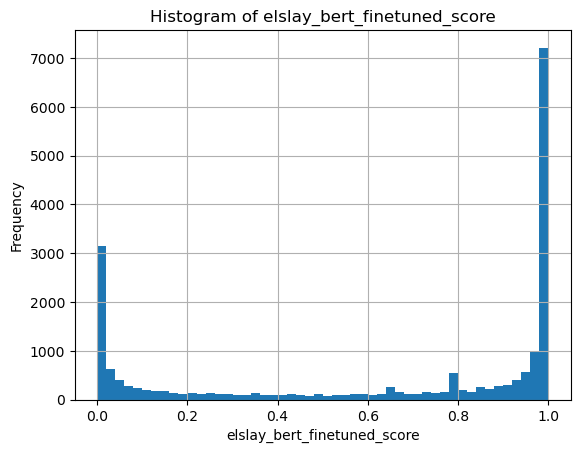

In [42]:
good_user_labeled_df['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_elslay_bert.png')

In [44]:
good_user_labeled_df[good_user_labeled_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    6258
Name: count, dtype: int64

In [45]:
6258*100/(13170+6830)

31.29

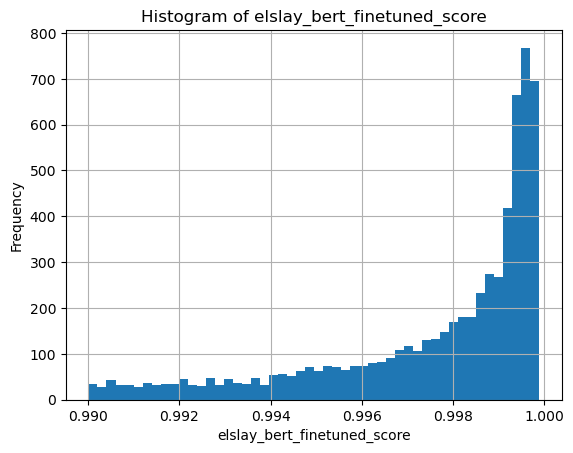

In [46]:
good_user_labeled_df[good_user_labeled_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_elslay_bert_0.99.png')

In [51]:
good_user_labeled_df['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    15331
0     4669
Name: count, dtype: int64

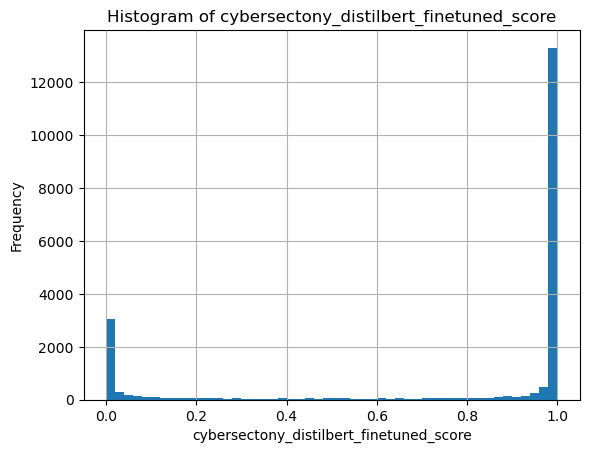

In [47]:
good_user_labeled_df['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_cybersectony_distilbert.png')

In [48]:
# good_user_labeled_df[good_user_labeled_df['elslay_bert_finetuned_score'] >= 0.99]['subject'].head(20)
good_user_labeled_df[good_user_labeled_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    12391
Name: count, dtype: int64

In [49]:
100*12391/20000

61.955

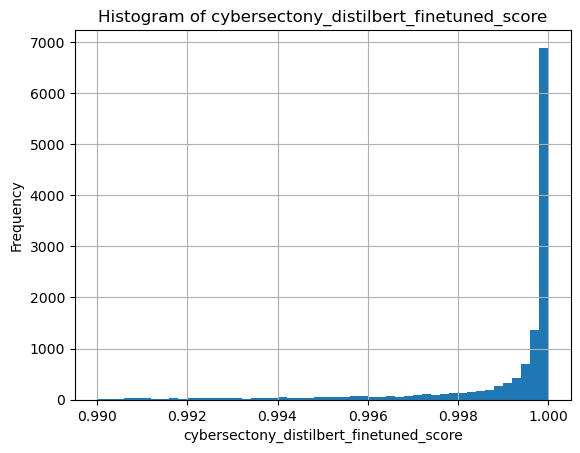

In [50]:
good_user_labeled_df[good_user_labeled_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_cybersectony_distilbert_0.99.png')

In [78]:
phish_user_df = merged.sort_values(by='elslay_bert_finetuned_score', ascending=False)

In [169]:
good_user_labeled_df = good_user_labeled_df.sort_values(by='elslay_bert_finetuned_score', ascending=False)

In [170]:
phish_user_df['dataset'] = 'Suspended User'
good_user_labeled_df['dataset'] = 'Good User'

In [171]:
phish_user_df.columns, good_user_labeled_df.columns

(Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'email_from', 'email_to',
        'email_date', 'originating_ip', 'originating_ip_country', 'lang',
        'Content-Type', 'translated_text', 'dataset',
        'elslay_bert_finetuned_score'],
       dtype='object'),
 Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'email_from', 'email_to',
        'email_date', 'originating_ip', 'originating_ip_country', 'lang',
        'Content-Type', 'email_text', 'cleaned_text', 'translated_text',
        'ealvaradob_bert_finetuned_label', 'ealvaradob_bert_finetuned_score',
        'elslay_bert_finetuned_label', 'elslay_bert_finetuned_score',
        'cybersectony_distilbert_finetuned_label',
        'cybersectony_distilbert_finetuned_score', 'subject_body', 'dataset'],
       dtype='object'))

In [172]:
phish_user_df = phish_user_df[['user_id', 'msg_id', 'sg_event_id', 'subject', 'email_from',
        'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
        'lang', 'Content-Type', 'translated_text', 'dataset', 'elslay_bert_finetuned_score']]
good_user_labeled_df = good_user_labeled_df[['user_id', 'msg_id', 'sg_event_id', 'subject', 'email_from',
        'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
        'lang', 'Content-Type', 'translated_text', 'dataset', 'elslay_bert_finetuned_score']]

In [173]:
top_100_all = pd.concat([phish_user_df[:50], good_user_labeled_df[:50]]).reset_index(drop=True)

In [84]:
top_100_all.head()

,user_id,msg_id,sg_event_id,subject,email_from,email_to,email_date,originating_ip,originating_ip_country,lang,Content-Type,translated_text,dataset,elslay_bert_finetuned_score
0,45492992,wprg3q4KSCSVSs60_c_2Pg.recvd-69cbc48b94-dfm74-...,cHJvY2Vzc2VkLTQ1NDkyOTkyLXdwcmczcTRLU0NTVlNzNj...,invoice #ID-221225046,"""SSA-StatementDept@ssa-updates.com"" <dm-norepl...",chsfinest3@aol.com,2025-04-01 00:00:00,185.148.181.13,United States,it,text/html,You chose to receive alerts whenever a record ...,Suspended User,0.999896
1,51155066,kM15Lq1fREGyLB__q9Psaw.recvd-578d769b87-6qrvf-...,cHJvY2Vzc2VkLTUxMTU1MDY2LWtNMTVMcTFmUkVHeUxCX1...,Votre futur financier se construit pas à pas,"""HéritageFutur"" <cathie@vie.simulationsfacile.fr>",kherianemenghour@yahoo.fr,2025-03-12 00:00:00,51.178.59.215,France,fr,text/html,You have the right to unsubscribe from our new...,Suspended User,0.999884
2,51155067,izz46s-iSPW3hzpFe3gaaw.recvd-canary-8bbfdcdfb-...,cHJvY2Vzc2VkLTUxMTU1MDY3LWl6ejQ2cy1pU1BXM2h6cE...,", offrez-vous le meilleur en matière de soins ...","""TrustFlex"" <alexandra@mutuelle.comparateurass...",jmarcq@yahoo.fr,2025-03-11 00:00:00,51.210.248.150,France,fr,text/html,You have the right to unsubscribe from our new...,Suspended User,0.999880
3,51155066,4-bwEHPGSuWnAKDf4bOiOw.recvd-668fcdfd56-ss4b6-...,cHJvY2Vzc2VkLTUxMTU1MDY2LTQtYndFSFBHU3VXbkFLRG...,Quelle courbe voulez-vous tracer ?,"""SèvePosthume"" <cathie@vie.simulationsfacile.fr>",tchanafrancis@yahoo.fr,2025-03-11 00:00:00,51.178.59.215,France,fr,text/html,You have the right to unsubscribe from our new...,Suspended User,0.999859
4,48321030,unvDB-s4ThmcFSgDMAxgFg.recvd-69cbc48b94-dfm74-...,cHJvY2Vzc2VkLTQ4MzIxMDMwLXVudkRCLXM0VGhtY0ZTZ0...,RE: Exclusive Funding - Two years no repayment,"""Oman & Emirates Holding Company"" <laspicom@la...",kenneth.anderson@catalent.com,2025-03-04 00:00:00,44.214.78.206,United States,en,text/html,Our top broker has introduced your contact to ...,Suspended User,0.999851


In [85]:
top_100_all.to_csv('csv_files/top_100_elslay.csv')

In [174]:
good_html = good_user_labeled_df[:50]

In [175]:
good_html['html_path'] = "s3://accsec-ai-prod-snitchmail/processed/not_phish/html_files/" + good_html['msg_id'] + ".html"

/tmp/ipykernel_19391/747987058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_html['html_path'] = "s3://accsec-ai-prod-snitchmail/processed/not_phish/html_files/" + good_html['msg_id'] + ".html"


In [176]:
dst = 'good_html'

for html_src in good_html['html_path'].tolist():
    key = html_src.split('/')[-1]
    wr.s3.download(html_src, dst + '/' + key)

# URLs as Inputs
## Phish User Dataset

In [101]:
phish_user_url_df = pd.read_parquet('csv_files/w_label/phish_user_emails_urls.parquet')
good_user_url_df = pd.read_parquet('csv_files/w_label/good_user_emails_urls.parquet')

In [99]:
phish_user_url_df.shape, phish_user_url_df.columns

((5599, 23),
 Index(['user_id', 'msg_id', 'sg_event_id', 'subject', 'mime', 'email_from',
        'email_to', 'email_date', 'originating_ip', 'originating_ip_country',
        'lang', 's3_path', 'Content-Type', 'email_text', 'cleaned_text',
        'translated_text', 'ealvaradob_bert_finetuned_label',
        'ealvaradob_bert_finetuned_score', 'elslay_bert_finetuned_label',
        'elslay_bert_finetuned_score',
        'cybersectony_distilbert_finetuned_label',
        'cybersectony_distilbert_finetuned_score', 'url_domains'],
       dtype='object'))

## 1. ealvaradob_bert

In [100]:
phish_user_url_df['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    5578
0      21
Name: count, dtype: int64

In [178]:
phish_user_url_df['url_domains'].value_counts()

url_domains
                                                                                 589
http://url5565.uk.rendaedinheiro.net                                             121
http://url7298.es1.guiabeneficios.com                                            121
http://url724.it.minhapme.com                                                    119
http://url8381.cl.recommendcentral.com                                           119
                                                                                ... 
https://u51727312.ct.sendgrid.net                                                  1
https://rarible-alert-forwarder.lovable.app https://u51770729.ct.sendgrid.net      1
www.pay-pal.com https://u51774167.ct.sendgrid.net                                  1
www.pay-pal.com https://u51774583.ct.sendgrid.net                                  1
www.pay-pal.com https://u51775666.ct.sendgrid.net                                  1
Name: count, Length: 197, dtype: int64

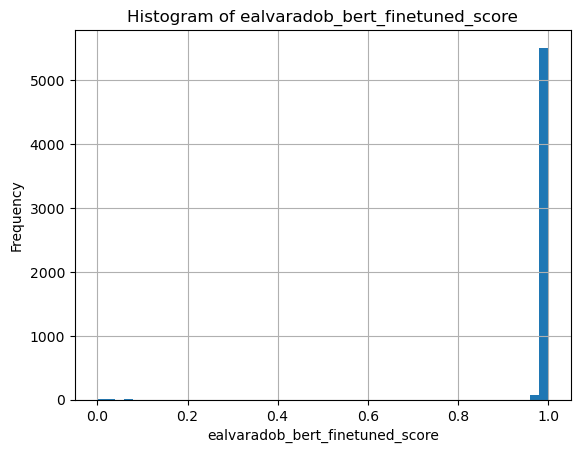

In [155]:
phish_user_url_df['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_ealvaradob_bert_url.png')

In [103]:
phish_user_url_df[phish_user_url_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    4920
Name: count, dtype: int64

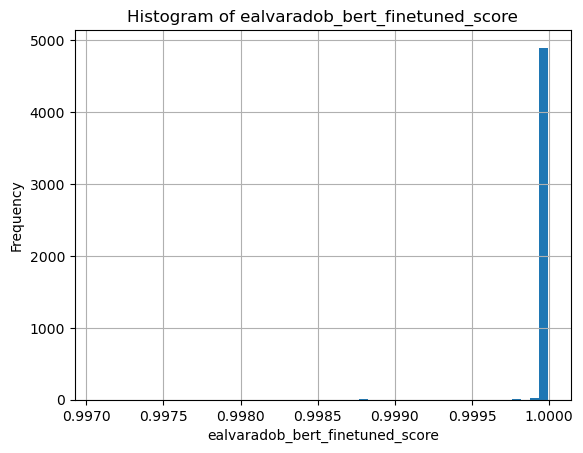

In [156]:
phish_user_url_df[phish_user_url_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_ealvaradob_bert_url_0.99.png')

In [102]:
good_user_url_df['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    17010
0     2990
Name: count, dtype: int64

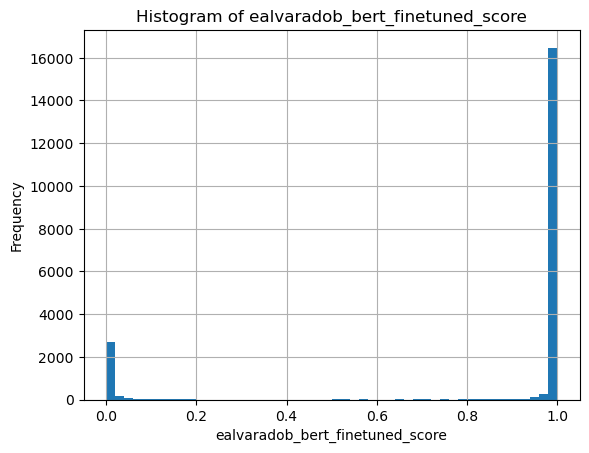

In [157]:
good_user_url_df['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_ealvaradob_bert_url.png')

In [104]:
good_user_url_df[good_user_url_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_label'].value_counts()

ealvaradob_bert_finetuned_label
1    9658
Name: count, dtype: int64

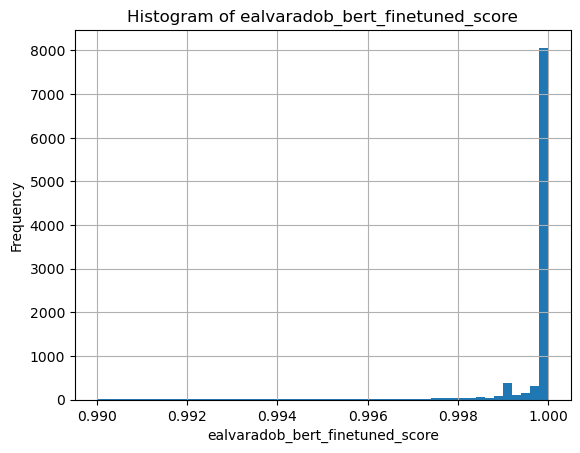

In [158]:
good_user_url_df[good_user_url_df['ealvaradob_bert_finetuned_score'] >= 0.99]['ealvaradob_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of ealvaradob_bert_finetuned_score')
plt.xlabel('ealvaradob_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_ealvaradob_bert_url_0.99.png')

## 2. elslay_bert

In [120]:
phish_user_url_df['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    5476
0     123
Name: count, dtype: int64

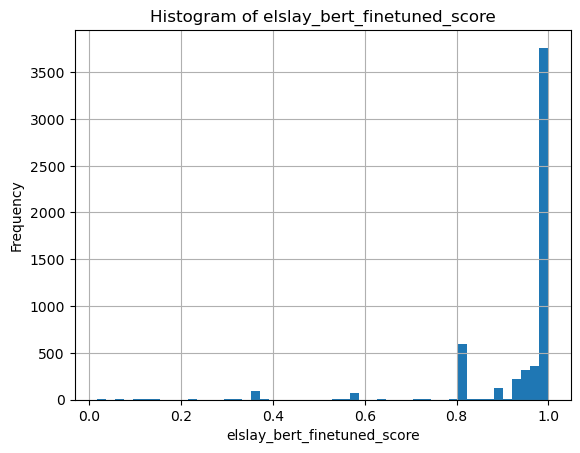

In [159]:
phish_user_url_df['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_elslay_bert_url.png')

In [153]:
phish_user_url_df[phish_user_url_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    3024
Name: count, dtype: int64

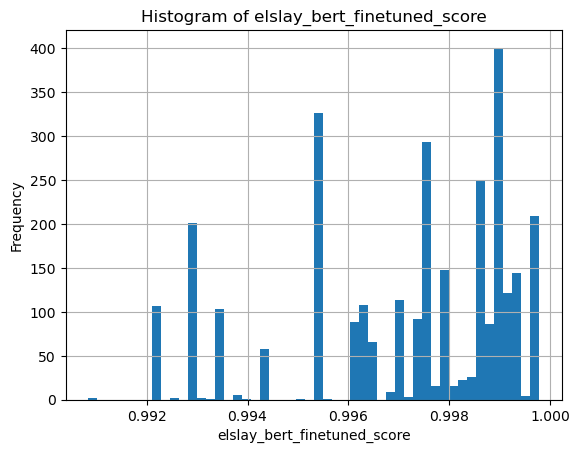

In [160]:
phish_user_url_df[phish_user_url_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_elslay_bert_url_0.99.png')

In [123]:
good_user_url_df['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    18197
0     1803
Name: count, dtype: int64

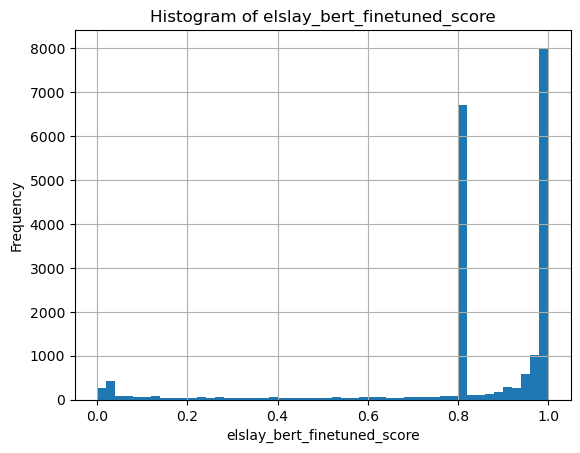

In [161]:
good_user_url_df['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_elslay_bert_url.png')

In [151]:
good_user_url_df[good_user_url_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_label'].value_counts()

elslay_bert_finetuned_label
1    7223
Name: count, dtype: int64

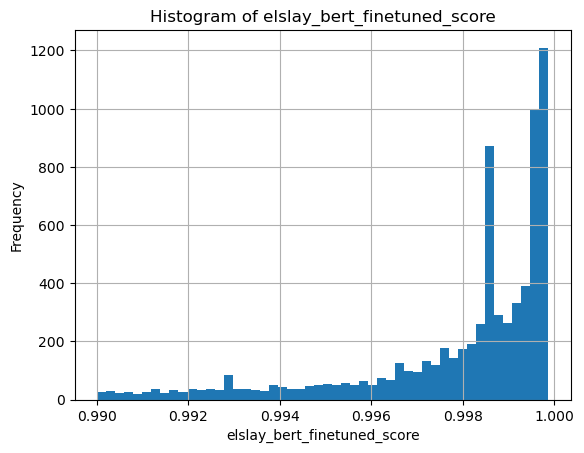

In [162]:
good_user_url_df[good_user_url_df['elslay_bert_finetuned_score'] >= 0.99]['elslay_bert_finetuned_score'].hist(bins=50)
plt.title('Histogram of elslay_bert_finetuned_score')
plt.xlabel('elslay_bert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_elslay_bert_url_0.99.png')

## 3. cybersectony_distilbert

In [106]:
phish_user_url_df['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    5577
0      22
Name: count, dtype: int64

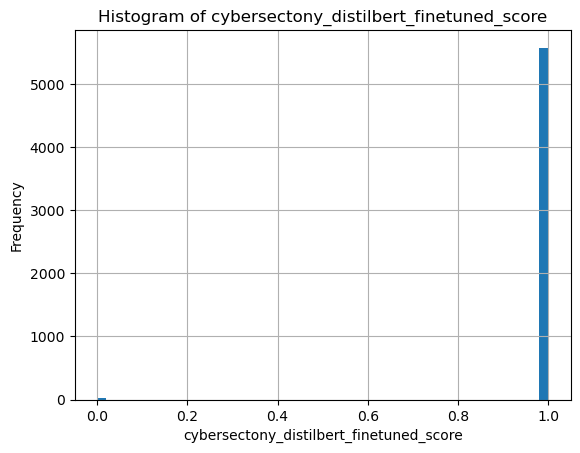

In [163]:
phish_user_url_df['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_cybersectony_distilbert_url.png')

In [107]:
phish_user_url_df[phish_user_url_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    5575
Name: count, dtype: int64

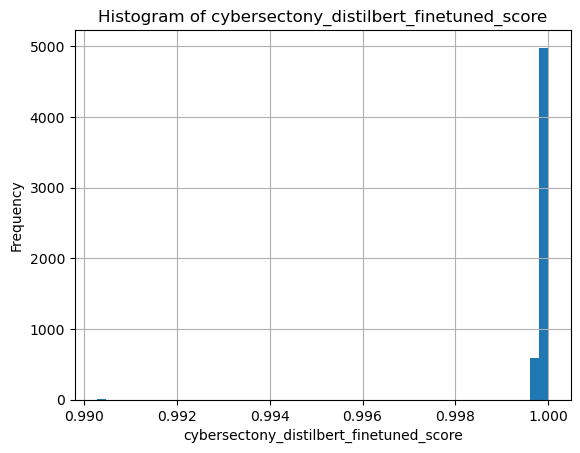

In [164]:
phish_user_url_df[phish_user_url_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/phish_cybersectony_distilbert_url_0.99.png')

In [119]:
# phish_user_url_df[phish_user_url_df['cybersectony_distilbert_finetuned_score'] >= 0.99].sort_values(by='cybersectony_distilbert_finetuned_score', ascending=False)[:10]

In [108]:
good_user_url_df['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    18285
0     1715
Name: count, dtype: int64

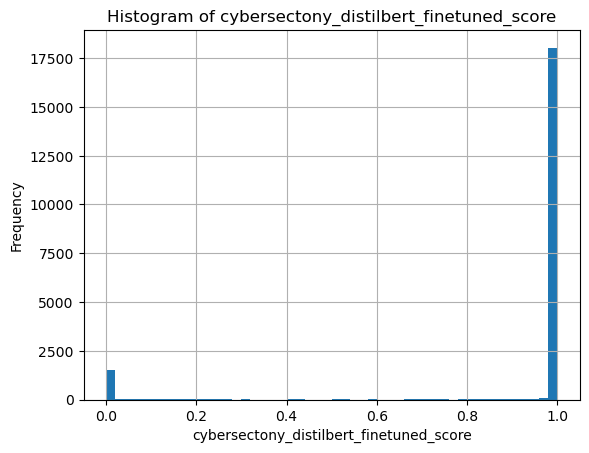

In [165]:
good_user_url_df['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_cybersectony_distilbert_url.png')

In [109]:
good_user_url_df[good_user_url_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_label'].value_counts()

cybersectony_distilbert_finetuned_label
1    17984
Name: count, dtype: int64

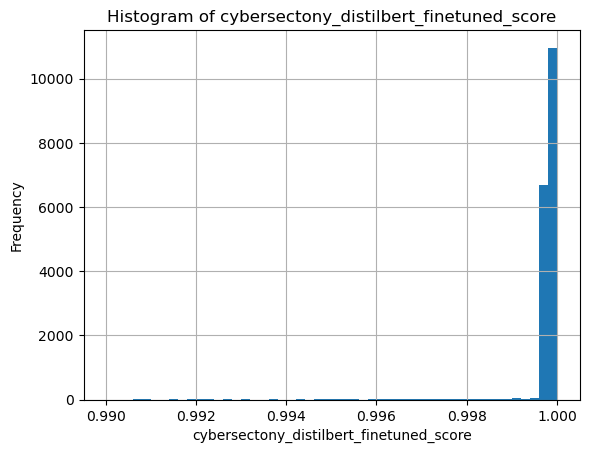

In [166]:
good_user_url_df[good_user_url_df['cybersectony_distilbert_finetuned_score'] >= 0.99]['cybersectony_distilbert_finetuned_score'].hist(bins=50)
plt.title('Histogram of cybersectony_distilbert_finetuned_score')
plt.xlabel('cybersectony_distilbert_finetuned_score')
plt.ylabel('Frequency')
plt.savefig('csv_files/figures/good_cybersectony_distilbert_url_0.99.png')